In [1]:
import numpy as np
import glob, os
from keras import layers as ly
from keras.models import Sequential, load_model, Model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.layers import Input, Lambda
from keras import losses
from keras.models import model_from_json
import keras.backend.tensorflow_backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
import string

Using TensorFlow backend.


In [2]:
#dir = './sequence/*'
dir = './datasets/seq/*'

In [3]:
# file read
all_names = []
all_data = []
sequence_length = []
alpha = list(string.ascii_uppercase)
data_length = len(glob.glob(dir))
file_predix = './datasets/seq/group'
for index in range(1, data_length+1):
    filename = file_predix + str(index) + "/*"
    print(filename)
    files = glob.glob(filename)
    for file in files:
        datasets = []
        all_names.append(file.split('/')[-1].replace('.txt', ''))
        for rf in open(file, 'r'):
            (u, v, w) = rf[1:-2].split(', ')
            datasets.append([alpha.index(u[1])+1, alpha.index(v[1]) +1, float(w)])
        sequence_length.append(len(datasets))
        all_data.append(datasets)
all_data = np.array([np.array(arr) for arr in all_data])

./datasets/seq/group1/*
./datasets/seq/group2/*
./datasets/seq/group3/*
./datasets/seq/group4/*
./datasets/seq/group5/*
./datasets/seq/group6/*
./datasets/seq/group7/*
./datasets/seq/group8/*
./datasets/seq/group9/*
./datasets/seq/group10/*
./datasets/seq/group11/*
./datasets/seq/group12/*
./datasets/seq/group13/*
./datasets/seq/group14/*
./datasets/seq/group15/*
./datasets/seq/group16/*


In [4]:
x_train, x_test, train_name, test_name = train_test_split(all_data, all_names, test_size=0.3)
x_test, x_val, test_name, val_name = train_test_split(x_test, test_name, test_size=0.33)

In [5]:
train_name
tr_names= []
for name in train_name:
    tr_names.append(name.split('graph')[0])
    #tr_names.append(name.split('-')[0].replace('graph', ''))

In [6]:
max_sequence_length = max(sequence_length)
n_features = 3
batch_size = 32
epochs = 500
steps_per_epoch = len(x_train)

In [7]:
def custom_loss(y_true, y_pred):
    loss1 = losses.mean_squared_error(y_true, y_pred)
    loss2 = losses.categorical_crossentropy(y_true, y_pred)
    return loss1 * 0.7 + loss2 * 0.3

In [8]:
def repeat_vector(args):
    layer_to_repeat = args[0]
    sequence_layer = args[1]
    return RepeatVector(K.shape(sequence_layer)[1])(layer_to_repeat)
    

inputs = Input(shape=(None, 3))
encoded = LSTM(128, return_sequences=True)(inputs)  #activation 안적으면 tanh
encoded = LSTM(64)(encoded)

decoded = Lambda(repeat_vector, output_shape=(None, 64)) ([encoded, inputs]) # inputs의 shape[1] 만큼 encoded 를 반복 생성

decoded = LSTM(64, return_sequences=True)(decoded)
decoded = LSTM(128, return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(3))(decoded)
encoder = Model(inputs, encoded)

lstm_autoencoder = Model(inputs, decoded)
lstm_autoencoder.compile(loss=custom_loss, optimizer='adam')#lr=1e-2, decay=0.9))
#lstm_autoencoder_500 = lstm_autoencoder

In [9]:
def val_generator(x_val):
    idx = 0
    while True:
        yield np.array([x_val[idx]]), np.array([x_val[idx]])
        idx += 1
        if idx >= len(x_val):
            idx = 0

def train_generator(x_train):
    idx = 0
    while True:
        yield np.array([x_train[idx]]), np.array([x_train[idx]])
        idx += 1
        if idx >= len(x_train):
            idx = 0

In [10]:
hist = lstm_autoencoder.fit_generator(train_generator(x_train), epochs=200, steps_per_epoch=steps_per_epoch, verbose=1, validation_steps=len(x_val), validation_data=val_generator(x_val))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/200
5770/5770 [==============================] - 83s 14ms/step - loss: 145.0791 - val_loss: 109.1718
Epoch 2/200
5770/5770 [==============================] - 89s 15ms/step - loss: 106.6896 - val_loss: 102.6890
Epoch 3/200
5770/5770 [==============================] - 89s 15ms/step - loss: 102.7500 - val_loss: 103.0718
Epoch 4/200
5770/5770 [==============================] - 89s 15ms/step - loss: 96.7037 - val_loss: 89.3877
Epoch 5/200
5770/5770 [==============================] - 90s 16ms/step - loss: 71.7778 - val_loss: 48.6010
Epoch 6/200
5770/5770 [==============================] - 90s 16ms/step - loss: 45.2307 - val_loss: 37.7671
Epoch 7/200
5770/5770 [==============================] - 90s 16ms/step - loss: 37.6227 - val_loss: 31.0102
Epoch 8/200
5770/5770 [==============================] - 90s 16ms/step - loss: 32.6279 - val_loss: 29.4200
Epoch 9/200
5770/5770 [====================

5770/5770 [==============================] - 88s 15ms/step - loss: 11.6602 - val_loss: 11.8535
Epoch 72/200
5770/5770 [==============================] - 88s 15ms/step - loss: 11.6922 - val_loss: 12.8382
Epoch 73/200
5770/5770 [==============================] - 88s 15ms/step - loss: 12.0119 - val_loss: 11.4964
Epoch 74/200
5770/5770 [==============================] - 88s 15ms/step - loss: 11.0466 - val_loss: 11.1959
Epoch 75/200
5770/5770 [==============================] - 89s 15ms/step - loss: 11.3095 - val_loss: 13.4963
Epoch 76/200
5770/5770 [==============================] - 88s 15ms/step - loss: 11.2822 - val_loss: 11.0364
Epoch 77/200
5770/5770 [==============================] - 89s 15ms/step - loss: 11.3713 - val_loss: 11.4914
Epoch 78/200
5770/5770 [==============================] - 88s 15ms/step - loss: 10.6888 - val_loss: 12.4241
Epoch 79/200
5770/5770 [==============================] - 89s 15ms/step - loss: 12.6205 - val_loss: 12.6518
Epoch 80/200
5770/5770 [=================

5770/5770 [==============================] - 87s 15ms/step - loss: 10.1656 - val_loss: 10.9126
Epoch 147/200
5770/5770 [==============================] - 87s 15ms/step - loss: 9.9512 - val_loss: 10.9258
Epoch 148/200
5770/5770 [==============================] - 87s 15ms/step - loss: 10.3550 - val_loss: 11.3760
Epoch 149/200
5770/5770 [==============================] - 87s 15ms/step - loss: 10.9736 - val_loss: 11.2014
Epoch 150/200
5770/5770 [==============================] - 87s 15ms/step - loss: 10.2439 - val_loss: 10.4909
Epoch 151/200
5770/5770 [==============================] - 87s 15ms/step - loss: 10.6206 - val_loss: 11.6086
Epoch 152/200
5770/5770 [==============================] - 87s 15ms/step - loss: 10.2268 - val_loss: 12.1870
Epoch 153/200
5770/5770 [==============================] - 87s 15ms/step - loss: 10.7692 - val_loss: 10.9276
Epoch 154/200
5770/5770 [==============================] - 87s 15ms/step - loss: 11.3082 - val_loss: 10.5915
Epoch 155/200
5770/5770 [=========

In [13]:
import json
model_json = lstm_autoencoder.to_json()
filename = 'new_cce_lstmae'  #input('filename: ') #
with open('res/cce/' + filename + '.json', 'w') as file:
    file.write(model_json)
lstm_autoencoder.save_weights('res/cce/weights_' +  filename + '.h5')

with open('res/last_cce_histroy.json', 'w') as f:
    json.dump(hist.history, f)

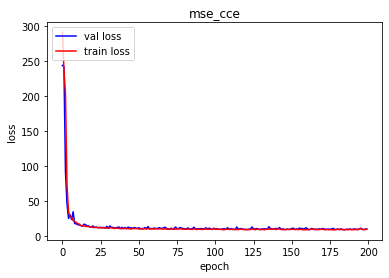

In [15]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['val_loss'], 'b', label='val loss')
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

plt.title('mse_cce')
plt.show()

In [38]:
loaded_model = lstm_autoencoder

In [39]:
mean= 0
for xt in x_test:
    xt = xt.reshape(1, xt.shape[0], xt.shape[1])
    out = loaded_model.predict(xt)
    mean += ((xt-out)**2).mean(axis=None)
print(mean/len(x_test))

0.36404565399193833


In [19]:
filename = "last_mse_lstmae_cce"
loaded_model = model_from_json(open('res/cce/' +filename + '.json').read())
loaded_model.load_weights('model_save/mse_cce_models/weights_' + filename + '.h5')

In [ ]:
encoder = Model(loaded_model.input, loaded_model.layers[3].output)

In [ ]:
test = x_test[0].reshape(1, x_test[0].shape[0], x_test[0].shape[1])
latent_vector = []
for x in x_test:
    x = x.reshape(1, x.shape[0], x.shape[1])
    latent_vector.append(encoder.predict(x)[0])

In [10]:
model_path = 'model_save/mse_cce_models/weights' + '{epoch:02d}-{loss:.4f}.h5'
early_stopping_callback = EarlyStopping(monitor='loss', patience=200)
checkpoint_callback = ModelCheckpoint(model_path, monitor='loss', verbose = 1, save_best_only = True, save_weights_only = True, mode='min')#, period=5)